# **Sentiment Analysis with Naive Bayes and Logistic Regression**

## **Preparing Dependencies**

**Download Dependencies**

In [64]:
#!pip install openpyxl
#!pip -q install sastrawi

**Import Dependencies**

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
import seaborn as sn
import nltk


from tqdm.notebook import tqdm
from tqdm import tqdm

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [66]:
# download Stopwords bahasa indonesia
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Load Dataset**

In [67]:
# membaca data dari file csv dengan menyertakan parameter delimeter
df = pd.read_excel('dataset/fix_dataset.xlsx')
df.head()

,Unnamed: 0.1,Unnamed: 0,author,authorIsChannelOwner,channelId,channelName,channelUrl,cid,comment,comments,...,text,thumbnailUrl,title,type,url,videoId,viewCount,voteCount,nama_channel,labeling
0,0,0,NaN,NaN,UCpTDLjtApqi9yAfHMDfVQIA,CVT Indonesia,https://www.youtube.com/@CVTIndonesia,NaN,NaN,NaN,...,NaN,NaN,PENASARAN SAMA MOBIL YANG DIPAGERAN INI? INI D...,shorts,https://www.youtube.com/shorts/57M48weGsSk,NaN,6700.0,NaN,Unknown,NaN
1,1,1,@MelvilleAlbert-h2j,0.0,NaN,NaN,NaN,Ugy0ll_PA3Vyar5HKKl4AaABAg,Harris Sarah Moore Maria Lopez John,NaN,...,NaN,NaN,Suzuki EVX Concept 2024 | First Impression | O...,comment,NaN,TrS87tu1lJ8,NaN,0.0,OtoDriver,netral
2,2,2,@inspirasitanparugi,0.0,NaN,NaN,NaN,Ugw4r_yUJlWl4WnDT-54AaABAg,Good Product for Suzuki Mobil ....Saya penggia...,NaN,...,NaN,NaN,Suzuki EVX Concept 2024 | First Impression | O...,comment,NaN,TrS87tu1lJ8,NaN,0.0,OtoDriver,positif
3,3,3,@dediksetiawan1287,0.0,NaN,NaN,NaN,UgwZQDF3JVn7TEE5lN94AaABAg,Eksterior & interiornya keren banget....sangat...,NaN,...,NaN,NaN,Suzuki EVX Concept 2024 | First Impression | O...,comment,NaN,TrS87tu1lJ8,NaN,0.0,OtoDriver,positif
4,4,4,@wisnudrajad,0.0,NaN,NaN,NaN,UgzfXB9RO5ZTXj9jUn94AaABAg,Mobil konsep = php,NaN,...,NaN,NaN,Suzuki EVX Concept 2024 | First Impression | O...,comment,NaN,TrS87tu1lJ8,NaN,0.0,OtoDriver,negatif


In [68]:
data = df[['comment', 'labeling']]
data = data.iloc[1:,:]
data.head()

,comment,labeling
1,Harris Sarah Moore Maria Lopez John,netral
2,Good Product for Suzuki Mobil ....Saya penggia...,positif
3,Eksterior & interiornya keren banget....sangat...,positif
4,Mobil konsep = php,negatif
5,Kabarnya tahun depan Suzuki bakal luncurin mob...,netral


## **Preprocessing**

### **Casefolding**

In [69]:
# Fungsi casefolding
def casefolding(text):
    if isinstance(text, str):  # Pastikan hanya string yang diproses
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Menghapus karakter non-alphabet
    return text

# Terapkan casefolding dengan memastikan setiap nilai diubah menjadi string
data["casefolding"] = data["comment"].apply(lambda x: casefolding(str(x)))

# Tampilkan data
data.head()


,comment,labeling,casefolding
1,Harris Sarah Moore Maria Lopez John,netral,harris sarah moore maria lopez john
2,Good Product for Suzuki Mobil ....Saya penggia...,positif,good product for suzuki mobil saya penggiat mo...
3,Eksterior & interiornya keren banget....sangat...,positif,eksterior interiornya keren bangetsangat futu...
4,Mobil konsep = php,negatif,mobil konsep php
5,Kabarnya tahun depan Suzuki bakal luncurin mob...,netral,kabarnya tahun depan suzuki bakal luncurin mob...


### **Normalisasi Kata**

In [70]:
key_norm = pd.read_csv('dataset/key_norm.csv')

def text_normalize(text):
    
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
    text = str.lower(text)
    
    return text

data['textnormalize'] = data['casefolding'].apply(text_normalize)
data.head()

,comment,labeling,casefolding,textnormalize
1,Harris Sarah Moore Maria Lopez John,netral,harris sarah moore maria lopez john,harris sarah moore maria lopez john
2,Good Product for Suzuki Mobil ....Saya penggia...,positif,good product for suzuki mobil saya penggiat mo...,good produk untuk suzuki mobil saya penggiat m...
3,Eksterior & interiornya keren banget....sangat...,positif,eksterior interiornya keren bangetsangat futu...,eksterior interiornya keren bangetsangat futur...
4,Mobil konsep = php,negatif,mobil konsep php,mobil konsep php
5,Kabarnya tahun depan Suzuki bakal luncurin mob...,netral,kabarnya tahun depan suzuki bakal luncurin mob...,kabarnya tahun depan suzuki bakal luncurin mob...


### **Stopwords Removal**

In [71]:
stopwords_ind = stopwords.words('indonesian')
stopwords_ind

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [72]:
# Membuat DataFrame dari daftar stopwords
stopwords_df = pd.DataFrame(stopwords_ind, columns=['stopwords'])

# Menyimpan DataFrame ke dalam file CSV
stopwords_df.to_csv('stopwords_indonesian.csv', index=False)

In [73]:
def remove_stop_words(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind:
            clean_words.append(word)
            
    return " ".join(clean_words)

data['stopwordremoval'] = data['textnormalize'].apply(remove_stop_words)
data.head()

,comment,labeling,casefolding,textnormalize,stopwordremoval
1,Harris Sarah Moore Maria Lopez John,netral,harris sarah moore maria lopez john,harris sarah moore maria lopez john,harris sarah moore maria lopez john
2,Good Product for Suzuki Mobil ....Saya penggia...,positif,good product for suzuki mobil saya penggiat mo...,good produk untuk suzuki mobil saya penggiat m...,good produk suzuki mobil penggiat mobil suzuki
3,Eksterior & interiornya keren banget....sangat...,positif,eksterior interiornya keren bangetsangat futu...,eksterior interiornya keren bangetsangat futur...,eksterior interiornya keren bangetsangat futur...
4,Mobil konsep = php,negatif,mobil konsep php,mobil konsep php,mobil konsep php
5,Kabarnya tahun depan Suzuki bakal luncurin mob...,netral,kabarnya tahun depan suzuki bakal luncurin mob...,kabarnya tahun depan suzuki bakal luncurin mob...,kabarnya suzuki luncurin mobil rakit indonesia...


### **Stemming**

In [74]:
# Set up the stemming factory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
    return stemmer.stem(text)

# Tambahkan support untuk tqdm pada pandas
tqdm.pandas()

# Terapkan stemming dengan tqdm untuk melihat progress
data['stemming'] = data['stopwordremoval'].progress_apply(stemming)

# Lihat hasilnya
data.head()

100%|██████████| 266/266 [01:54<00:00,  2.33it/s]


,comment,labeling,casefolding,textnormalize,stopwordremoval,stemming
1,Harris Sarah Moore Maria Lopez John,netral,harris sarah moore maria lopez john,harris sarah moore maria lopez john,harris sarah moore maria lopez john,harris sarah moore maria lopez john
2,Good Product for Suzuki Mobil ....Saya penggia...,positif,good product for suzuki mobil saya penggiat mo...,good produk untuk suzuki mobil saya penggiat m...,good produk suzuki mobil penggiat mobil suzuki,good produk suzuki mobil giat mobil suzuki
3,Eksterior & interiornya keren banget....sangat...,positif,eksterior interiornya keren bangetsangat futu...,eksterior interiornya keren bangetsangat futur...,eksterior interiornya keren bangetsangat futur...,eksterior interior keren bangetsangat futurist...
4,Mobil konsep = php,negatif,mobil konsep php,mobil konsep php,mobil konsep php,mobil konsep php
5,Kabarnya tahun depan Suzuki bakal luncurin mob...,netral,kabarnya tahun depan suzuki bakal luncurin mob...,kabarnya tahun depan suzuki bakal luncurin mob...,kabarnya suzuki luncurin mobil rakit indonesia...,kabar suzuki luncurin mobil rakit indonesia ckd


In [75]:
data["clean_text"] = data['stemming']

data.drop(["casefolding","textnormalize","stopwordremoval","stemming"],axis=1,inplace=True)
data.head()

,comment,labeling,clean_text
1,Harris Sarah Moore Maria Lopez John,netral,harris sarah moore maria lopez john
2,Good Product for Suzuki Mobil ....Saya penggia...,positif,good produk suzuki mobil giat mobil suzuki
3,Eksterior & interiornya keren banget....sangat...,positif,eksterior interior keren bangetsangat futurist...
4,Mobil konsep = php,negatif,mobil konsep php
5,Kabarnya tahun depan Suzuki bakal luncurin mob...,netral,kabar suzuki luncurin mobil rakit indonesia ckd


### **Other Cleaning**

In [76]:
data = data[data["clean_text"]!=""]
data

,comment,labeling,clean_text
1,Harris Sarah Moore Maria Lopez John,netral,harris sarah moore maria lopez john
2,Good Product for Suzuki Mobil ....Saya penggia...,positif,good produk suzuki mobil giat mobil suzuki
3,Eksterior & interiornya keren banget....sangat...,positif,eksterior interior keren bangetsangat futurist...
4,Mobil konsep = php,negatif,mobil konsep php
5,Kabarnya tahun depan Suzuki bakal luncurin mob...,netral,kabar suzuki luncurin mobil rakit indonesia ckd
...,...,...,...
262,Ahh baru concept rilisnya jauh😂😂😂,negatif,ahh konsep rilis
263,Headunit nya ganggu pandangan banget seperti nya,negatif,headunit nya ganggu pandang banget nya
264,Kayaknya ini bukan bikinan Suzuki India deh..,positif,kayak bikin suzuki india deh
265,maklum indo pajaknya besar bang untuk unit import,netral,maklum indonesia pajak bang unit import


In [77]:
data['labeling'].value_counts()

labeling
positif    114
negatif     99
netral      50
Name: count, dtype: int64

In [78]:
data = data[data['labeling'] != 'netral']
data

,comment,labeling,clean_text
2,Good Product for Suzuki Mobil ....Saya penggia...,positif,good produk suzuki mobil giat mobil suzuki
3,Eksterior & interiornya keren banget....sangat...,positif,eksterior interior keren bangetsangat futurist...
4,Mobil konsep = php,negatif,mobil konsep php
6,Nanti udh jadi harganya di mark up sama salesn...,negatif,harga mark up salesnya arepin suzuki
7,Kedepannya pasti\nCBU Suzuki Maruti INDIA\n😂😂😂,negatif,depan cbu suzuki marut india
...,...,...,...
259,Next tukar tambah sama xl 7,positif,next tukar xl 7
261,"sayang masih konsep, mobil cina sdh banjir...",negatif,sayang konsep mobil cina banjir
262,Ahh baru concept rilisnya jauh😂😂😂,negatif,ahh konsep rilis
263,Headunit nya ganggu pandangan banget seperti nya,negatif,headunit nya ganggu pandang banget nya


## **Visualization**

**Plot Sentimen tiap Channel**

<Axes: xlabel='nama_channel'>

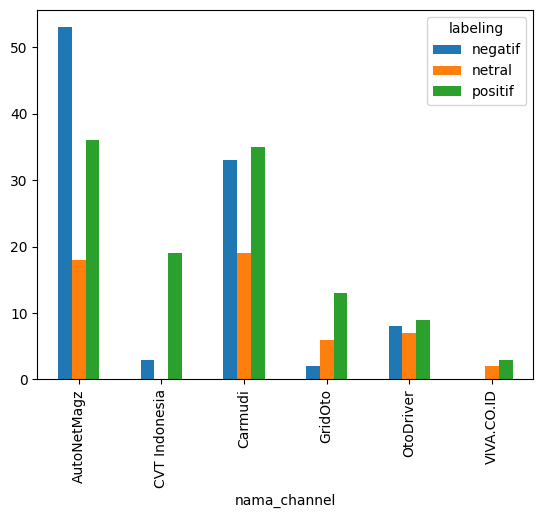

In [79]:
sentimen_tiap_channel = pd.pivot_table(index = 'nama_channel', columns = 'labeling', aggfunc = 'size', data = df, fill_value = 0)

sentimen_tiap_channel.plot(kind = 'bar')

**WordCloud Tiap Sentimen**

In [80]:
from wordcloud import WordCloud

In [81]:
def word_cloud_from_sentimen(data, sentimen) :
    sentimen_data = data[data['labeling'] == sentimen]
    
    sentimen_text = ' '.join(sentimen_data["clean_text"].values.tolist())
    
    wordcloud_sentimen = WordCloud(width  = 800, 
                                   height = 800,
                                   background_color = 'white',
                                   stopwords = None,
                                   min_font_size = 10).generate(sentimen_text)
    
    plt.figure(figsize=(16, 9))
    plt.imshow(wordcloud_sentimen, interpolation='bilinear')
    plt.title(f'Sentimen {sentimen.title()}')
    plt.axis('off')
    plt.show()

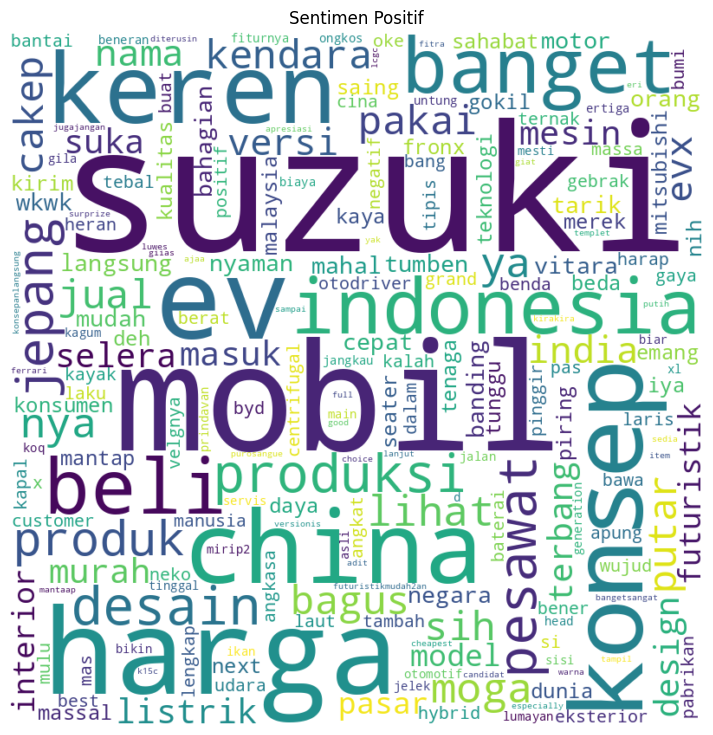

In [82]:
word_cloud_from_sentimen(data, 'positif')

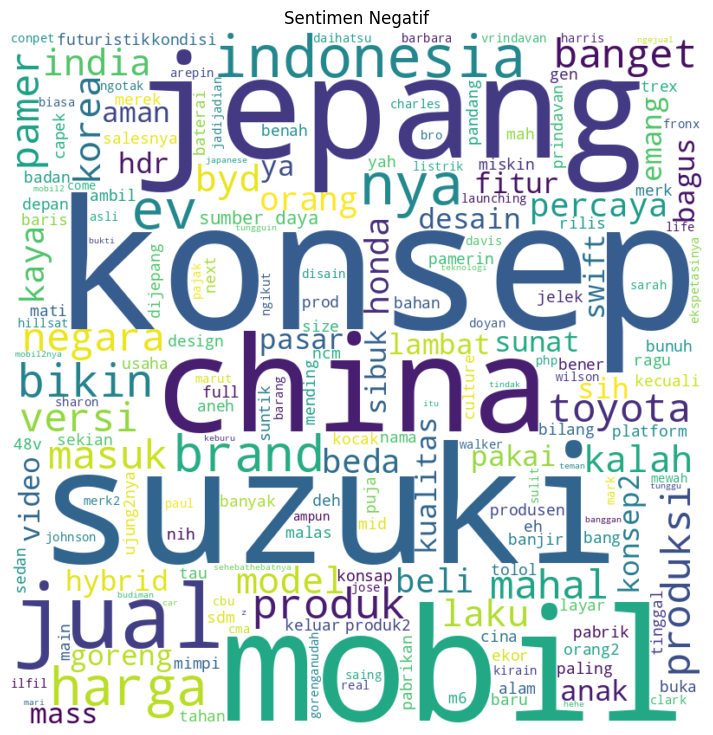

In [83]:
word_cloud_from_sentimen(data, 'negatif')

## **Splitting Data**

In [84]:
X_raw = data["clean_text"]
y_raw = data["labeling"]

#memisahkan menjadi 2 bagian yaitu 20% data uji 80% data latih
X_train, X_test, y_train, y_test = train_test_split(X_raw.values, y_raw.values, test_size = 0.2, random_state=42, stratify = y_raw)

## **Feature Extraction**

In [85]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train)

TfidfVectorizer(ngram_range=(1, 2))

In [86]:
X_train_TFIDF = vectorizer.transform(X_train).toarray()
X_test_TFIDF  = vectorizer.transform(X_test).toarray() 

X = vectorizer.transform(data["clean_text"]).toarray()

kolom = vectorizer.get_feature_names_out()

train_tf_idf = pd.DataFrame(X_train_TFIDF, columns=kolom)
test_tf_idf  = pd.DataFrame(X_test_TFIDF,  columns=kolom)
train_tf_idf.head()

,0429,0429 susah,100,100 beli,100 ton,11000,11000 unit,1112,1112 daihatsu,12v,...,yak,yaris,yaris cross,yen,yen anjlok,yh,yup,yup mazda,zennix,zennix badan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Plot TF-IDF**

In [87]:
colors = sn.color_palette("viridis", n_colors = 3)

- **Top 10 Kata Kunci dengan Nilai Rata-rata TF-IDF (Data Training)**

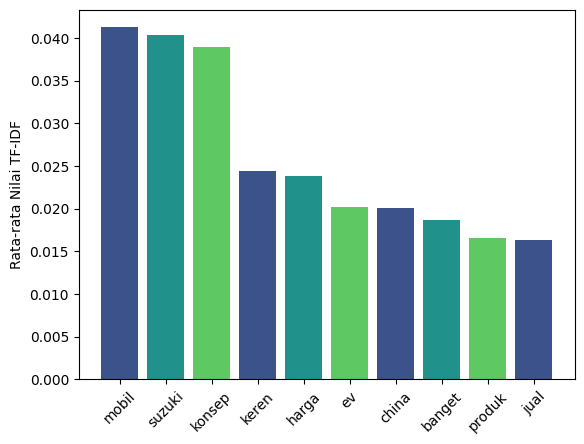

In [88]:
mean_tfidf = train_tf_idf.mean().sort_values(ascending=False).head(10)

fig, ax = plt.subplots()

ax.bar(mean_tfidf.index, mean_tfidf.values, color = colors)
ax.set_ylabel('Rata-rata Nilai TF-IDF')

plt.xticks(rotation = 45) ;

- **Top 10 Kata Kunci dengan Nilai Rata-rata TF-IDF (Data Testing)**

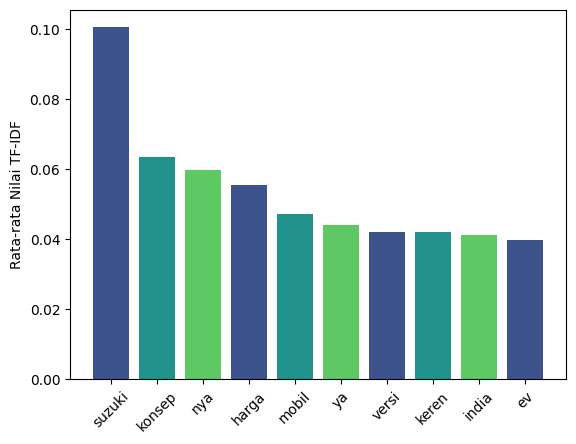

In [89]:
mean_tfidf = test_tf_idf.mean().sort_values(ascending=False).head(10)

fig, ax = plt.subplots()
    
ax.bar(mean_tfidf.index, mean_tfidf.values, color = colors)
ax.set_ylabel('Rata-rata Nilai TF-IDF')
plt.xticks(rotation = 45) ; 

## **Feature Selection**

### **Feature Selection dengan k = 500**

In [90]:
chi2_500_features   = SelectKBest(chi2, k = 500)

X_500_best_features = chi2_500_features.fit_transform(train_tf_idf, y_train)

print('Banyaknya fitur awal:', train_tf_idf.shape[1])
print('banyaknya fitur setelah di seleksi:', X_500_best_features.shape[1])


Banyaknya fitur awal: 2214
banyaknya fitur setelah di seleksi: 500


In [91]:
selected_500_feature_names = [kolom[i] for i in chi2_500_features.get_support(indices=True)]

# Create a DataFrame with the selected features
selected_500_train_tf_idf = pd.DataFrame(X_500_best_features, columns = selected_500_feature_names)

# Save the DataFrame to an Excel file
selected_500_train_tf_idf.to_excel('selected_TF_IDF_500_features_sastrawi.xlsx', index=False)

### **Feature Selection with k in range (501-2000)**

In [92]:
def model_performance_with_feature_selection_with_k_feature(start, end, model_) :
    
    k_feature_acc , k_feature_f1 , max_acc , max_f1 = [0, 0, 0, 0]

    k = []
    acc = []
    f1 = []

    # Loop untuk memilih fitur terbaik dan menghitung skor
    for feature in tqdm(range(start, end + 1)) :
        
        chi2_features = SelectKBest(chi2, k = feature)
        X_kbest_features = chi2_features.fit_transform(train_tf_idf.values, y_train)
        
        model = model_

        model.fit(X_kbest_features, y_train)

        # Transformasi data uji menggunakan chi2_features
        X_test_ch2 = chi2_features.transform(X_test_TFIDF)

        # Prediksi label untuk data uji
        y_pred = model.predict(X_test_ch2)

        # Hitung akurasi dan F1-Score
        acc_temp = accuracy_score(y_test, y_pred)
        f1_temp  = f1_score(y_test, y_pred, average = "weighted")

        k.append(feature)
        acc.append(acc_temp)
        f1.append(f1_temp)

        # Update hasil terbaik jika ditemukan skor yang lebih tinggi
        if max_acc < acc_temp:
            max_acc = acc_temp
            k_feature_acc = feature
            
        if max_f1 < f1_temp:
            max_f1 = f1_temp
            k_feature_f1 = feature

    hasil = {'max_accuracy' : max_acc,
             'max_f1_score' : max_f1,  
             'k_feature_acc': k_feature_acc,
             'k_feature_f1' : k_feature_f1,
             'k_history'    : k,
             'acc_history'  : acc, 
             'f1_history'   : f1}
    
    return hasil

## **Modelling**

#### **Support Function**

In [93]:
def confusion_matrix_plot(y_test, y_pred) :
    kolom = ['negatif', 'positif']

    confm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(confm, index = kolom, columns=kolom)

    ax = sn.heatmap(df_cm, cmap='Greens', annot=True, fmt=".0f")

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Sentimen Sebenarnya')
    ax.set_ylabel('Sentimen Prediksi')

    ax.invert_xaxis()

    plt.show()

In [94]:
def k_features_performance_plot(k, acc, f1) :
    fig, ax = plt.subplots(2, 1)

    ax[0].plot(k, acc, color = 'red')
    ax[0 ].set_title('Accuracy dari setiap k-feature')

    ax[1].plot(k, f1)
    ax[1].set_title('F1-Score dari setiap k-feature')

    plt.tight_layout()

    plt.show()

### **Gaussian Naive Bayes**

#### **All Features**

- **Preparing Model**

In [95]:
gnb_all_features = GaussianNB()
gnb_all_features.fit(X_train_TFIDF, y_train)

GaussianNB()

- **Classification Report**

In [96]:
y_pred_gnb_all  = gnb_all_features.predict(X_test_TFIDF)

print(classification_report(y_test, y_pred_gnb_all))

              precision    recall  f1-score   support

     negatif       0.67      0.80      0.73        20
     positif       0.79      0.65      0.71        23

    accuracy                           0.72        43
   macro avg       0.73      0.73      0.72        43
weighted avg       0.73      0.72      0.72        43



- **Confusion Matrix Heatmap**

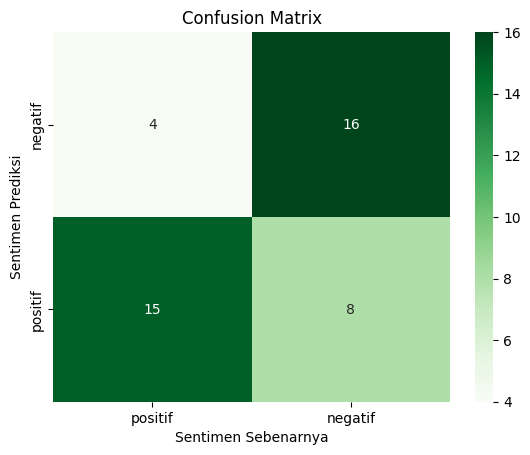

In [97]:
confusion_matrix_plot(y_test, y_pred_gnb_all)

#### **With 500 Features**

- **Preparing Model**

In [98]:
gnb_500 = GaussianNB()
gnb_500.fit(X_500_best_features, y_train)

GaussianNB()

- **Classification Report**

In [99]:
X_test_gnb_500 = chi2_500_features.transform(X_test_TFIDF)
y_pred_gnb_500 = gnb_500.predict(X_test_gnb_500)

print(classification_report(y_test, y_pred_gnb_500))

              precision    recall  f1-score   support

     negatif       0.57      0.20      0.30        20
     positif       0.56      0.87      0.68        23

    accuracy                           0.56        43
   macro avg       0.56      0.53      0.49        43
weighted avg       0.56      0.56      0.50        43



c:\Users\user\miniconda3\envs\ml-engineer\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


- **Confusion Matrix Heatmap**


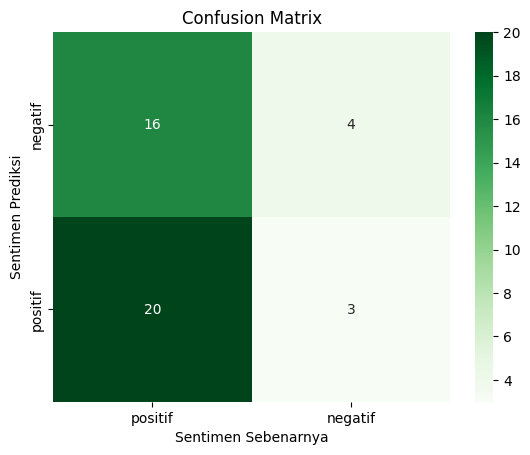

In [100]:
confusion_matrix_plot(y_test, y_pred_gnb_500)

#### **Eksperimen Feature Selection dengan 10-2000 Feature**

- **Performance**  

In [101]:
k_gnb_performance = model_performance_with_feature_selection_with_k_feature(model_ = GaussianNB(), start = 501, end = 2000)

k_gnb_max_acc     = k_gnb_performance['max_accuracy']
k_gnb_max_f1      = k_gnb_performance['max_f1_score']
k_gnb_k_history   = k_gnb_performance['k_history']
k_gnb_acc_history = k_gnb_performance['acc_history']
k_gnb_f1_history  = k_gnb_performance['f1_history']

k_gnb_num_feature_acc = k_gnb_performance['k_feature_acc']
k_gnb_num_feature_f1  = k_gnb_performance['k_feature_f1']

100%|██████████| 1500/1500 [00:27<00:00, 54.10it/s]


In [102]:
print(f"Accuracy terbaik adalah {k_gnb_max_acc} dengan banyaknya fitur {k_gnb_num_feature_acc}")
print(f"F1-Score terbaik adalah {k_gnb_max_f1} dengan banyaknya fitur  {k_gnb_num_feature_f1}")

Accuracy terbaik adalah 0.7209302325581395 dengan banyaknya fitur 1992
F1-Score terbaik adalah 0.7203261854424646 dengan banyaknya fitur  1992


- **Plot Accuracy dan F1-Score tiap K-Feature**

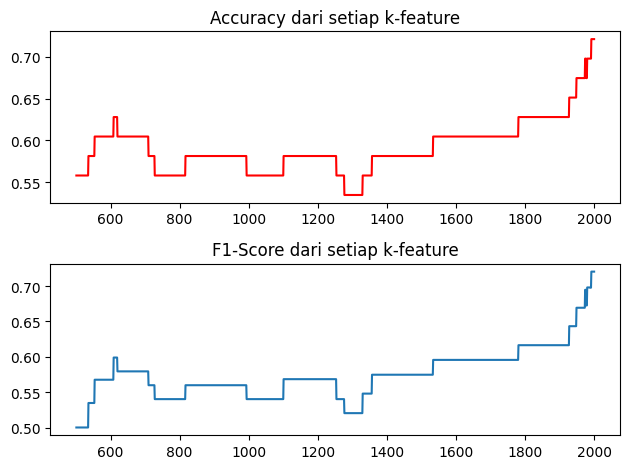

In [103]:
k_features_performance_plot(k_gnb_k_history, k_gnb_acc_history, k_gnb_f1_history)

- **Feature Selection dengan K = 1992 (Hasil Eksperimen)**

In [104]:
chi2_features = SelectKBest(chi2, k = k_gnb_num_feature_f1)
X_kbest_gnb_features = chi2_features.fit_transform(train_tf_idf.values, y_train)

print('Banyaknya fitur awal:', train_tf_idf.shape[1])
print('Banyaknya fitur setelah diseleksi:', X_kbest_gnb_features.shape[1])

Banyaknya fitur awal: 2214
Banyaknya fitur setelah diseleksi: 1992


- **Classification Report**

In [105]:
k_gnb = GaussianNB()
k_gnb.fit(X_kbest_gnb_features, y_train)

X_test_ch2 = chi2_features.transform(X_test_TFIDF)

# Prediksi label untuk data uji
y_pred_k_gnb = k_gnb.predict(X_test_ch2)

accuracy_k_gnb = accuracy_score(y_test, y_pred_k_gnb)

print(classification_report(y_test, y_pred_k_gnb))

              precision    recall  f1-score   support

     negatif       0.67      0.80      0.73        20
     positif       0.79      0.65      0.71        23

    accuracy                           0.72        43
   macro avg       0.73      0.73      0.72        43
weighted avg       0.73      0.72      0.72        43



- **Confusion Matrix Heatmap**

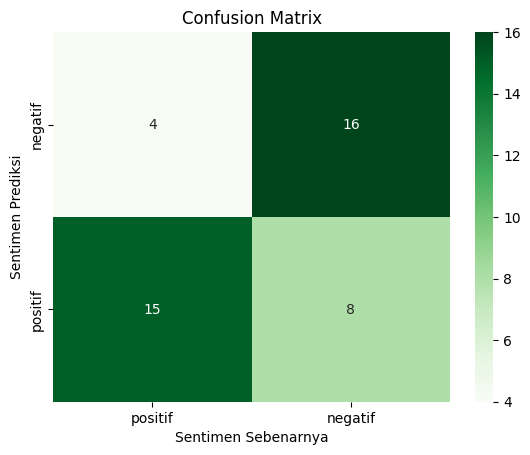

In [106]:
confusion_matrix_plot(y_test, y_pred_k_gnb)

### **Logistic Regression**

#### **All Features**

- **Preparing Model**

In [107]:
lr_all_features = LogisticRegression(C = 10.0, fit_intercept = False)
lr_all_features.fit(X_train_TFIDF, y_train)

LogisticRegression(C=10.0, fit_intercept=False)

- **Classification Report**

In [108]:
y_pred_lr_all = lr_all_features.predict(X_test_TFIDF)

print(classification_report(y_test, y_pred_lr_all))

              precision    recall  f1-score   support

     negatif       0.82      0.70      0.76        20
     positif       0.77      0.87      0.82        23

    accuracy                           0.79        43
   macro avg       0.80      0.78      0.79        43
weighted avg       0.79      0.79      0.79        43



- **Confusion Matrix Heatmap**

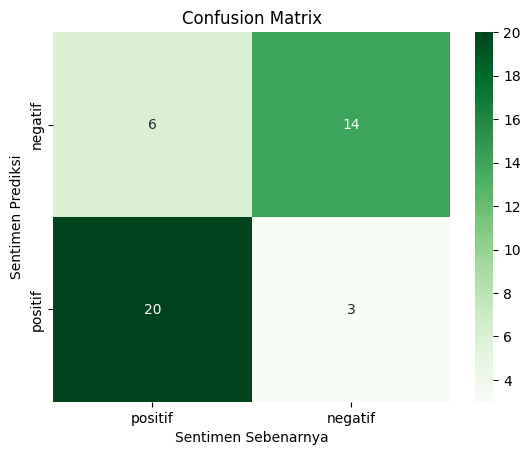

In [109]:
confusion_matrix_plot(y_test, y_pred_lr_all)

#### **With 500 Features**

- **Preparing Model**

In [110]:
lr_500 = LogisticRegression(C = 10.0, fit_intercept = False)
lr_500.fit(X_500_best_features, y_train)

LogisticRegression(C=10.0, fit_intercept=False)

- **Classification Report**

In [111]:
X_test_lr_500 = chi2_500_features.transform(X_test_TFIDF)
y_pred_lr_500 = lr_500.predict(X_test_lr_500)

print(classification_report(y_test, y_pred_lr_500))

              precision    recall  f1-score   support

     negatif       0.79      0.75      0.77        20
     positif       0.79      0.83      0.81        23

    accuracy                           0.79        43
   macro avg       0.79      0.79      0.79        43
weighted avg       0.79      0.79      0.79        43



c:\Users\user\miniconda3\envs\ml-engineer\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


- **Confusion Matrix Heatmap**

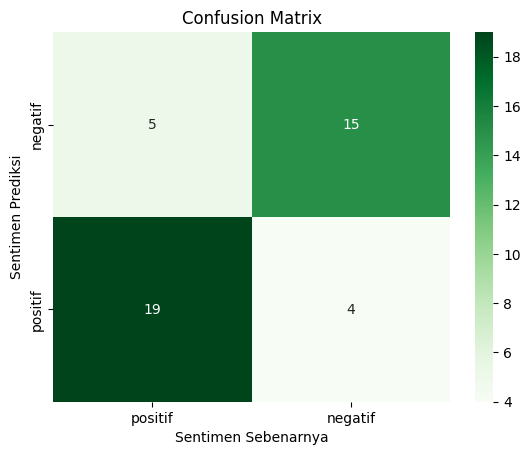

In [112]:
confusion_matrix_plot(y_test, y_pred_lr_500)

#### **Eksperimen Feature Selection dengan 10-2000 Feature**

- **Performance**  


In [113]:
k_lr_performance = model_performance_with_feature_selection_with_k_feature(model_ = LogisticRegression(C = 10.0, fit_intercept = False), start = 501, end = 2000)

k_lr_max_acc     = k_lr_performance['max_accuracy']
k_lr_max_f1      = k_lr_performance['max_f1_score']
k_lr_k_history   = k_lr_performance['k_history']
k_lr_acc_history = k_lr_performance['acc_history']
k_lr_f1_history  = k_lr_performance['f1_history']

k_lr_num_feature_acc = k_lr_performance['k_feature_acc']
k_lr_num_feature_f1  = k_lr_performance['k_feature_f1']

100%|██████████| 1500/1500 [00:32<00:00, 46.01it/s]


In [114]:
print(f"Accuracy terbaik adalah {k_lr_max_acc} dengan banyaknya fitur {k_lr_num_feature_acc}")
print(f"F1-Score terbaik adalah {k_lr_max_f1} dengan banyaknya fitur  {k_lr_num_feature_f1}")

Accuracy terbaik adalah 0.8372093023255814 dengan banyaknya fitur 1524
F1-Score terbaik adalah 0.8368540580316928 dengan banyaknya fitur  1524


- **Plot Accuracy dan F1-Score tiap K-Feature**

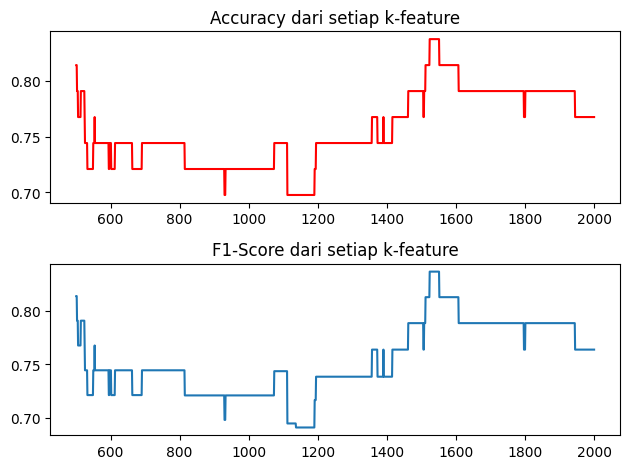

In [115]:
k_features_performance_plot(k_lr_k_history, k_lr_acc_history, k_lr_f1_history)

- **Feature Selection dengan K = 1543 (Hasil Eksperimen)**

In [116]:
chi2_features = SelectKBest(chi2, k = k_lr_num_feature_f1)
X_kbest_lr_features = chi2_features.fit_transform(train_tf_idf.values, y_train)

print('Banyaknya fitur awal:', train_tf_idf.shape[1])
print('Banyaknya fitur setelah diseleksi:', X_kbest_lr_features.shape[1])

Banyaknya fitur awal: 2214
Banyaknya fitur setelah diseleksi: 1524


- **Classification Report**

In [117]:
k_lr = LogisticRegression(C = 10.0, fit_intercept = False)
k_lr.fit(X_kbest_lr_features, y_train)

X_test_ch2 = chi2_features.transform(X_test_TFIDF)

# Prediksi label untuk data uji
y_pred_k_lr = k_lr.predict(X_test_ch2)

accuracy_k_lr = accuracy_score(y_test, y_pred_k_lr)

print(classification_report(y_test, y_pred_k_lr))

              precision    recall  f1-score   support

     negatif       0.84      0.80      0.82        20
     positif       0.83      0.87      0.85        23

    accuracy                           0.84        43
   macro avg       0.84      0.83      0.84        43
weighted avg       0.84      0.84      0.84        43



- **Confusion Matrix Heatmap**

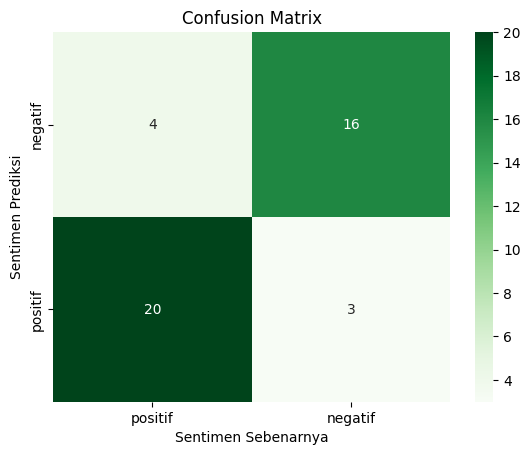

In [118]:
confusion_matrix_plot(y_test, y_pred_k_lr)